Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 4s - loss: 190.3132 - val_loss: 171.9039
Epoch 2/50
 - 3s - loss: 169.8076 - val_loss: 167.7884
Epoch 3/50
 - 3s - loss: 166.6002 - val_loss: 165.5432
Epoch 4/50
 - 3s - loss: 164.4614 - val_loss: 163.8432
Epoch 5/50
 - 3s - loss: 162.9359 - val_loss: 162.9362
Epoch 6/50
 - 3s - loss: 161.7085 - val_loss: 161.5335
Epoch 7/50
 - 3s - loss: 160.6472 - val_loss: 160.4108
Epoch 8/50
 - 3s - loss: 159.5965 - val_loss: 159.9529
Epoch 9/50
 - 3s - loss: 158.6400 - val_loss: 158.7512
Epoch 10/50
 - 3s - loss: 157.7317 - val_loss: 158.0299
Epoch 11/50
 - 3s - loss: 157.0112 - val_loss: 157.1109
Epoch 12/50
 - 3s - loss: 156.4125 - val_loss: 156.4905
Epoch 13/50
 - 3s - loss: 155.8749 - val_loss: 156.1208
Epoch 14/50
 - 3s - loss: 155.4004 - val_loss: 155.7014
Epoch 15/50
 - 3s - loss: 154.9371 - val_loss: 155.3211
Epoch 16/50
 - 3s - loss: 154.5850 - val_loss: 155.3176
Epoch 17/50
 - 3s - loss: 154.2349 - val_loss: 154.7669
Epoch 1

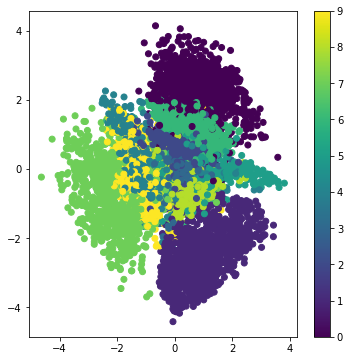

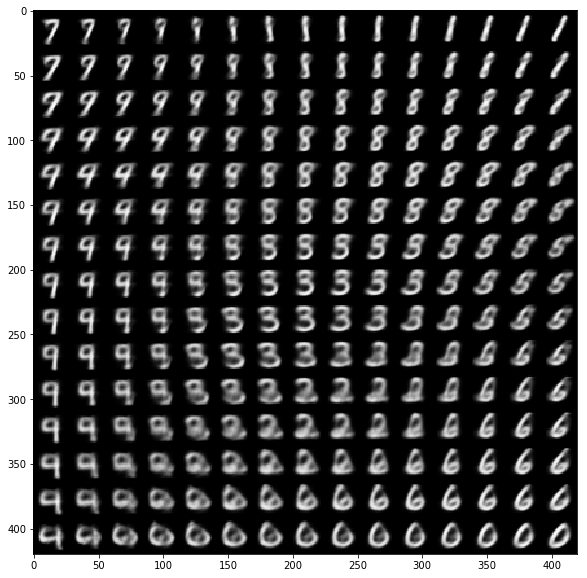

In [3]:
'''This script demonstrates how to build a variational autoencoder with Keras.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[EarlyStopping()])

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [3]:
from keras.datasets import mnist
import numpy as np
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
x_train.shape

(60000, 28, 28, 1)